In [5]:
import numpy as np
import matplotlib.pyplot as plt
import model_base as mb
from experiments import get_null_ff_input_arrays

In [6]:
# define parameter dictionaries
N_cells, w_mean, conn_prob, bg_inputs, taus = mb.get_default_params(flag_mean_pop=True)

# LH predictive coding params:
# w_mean_update = dict(EP=2, DE=0.5, DS=0.5, PE=1.2, PP=1, PS=0.3, PV=0.3, SE=1, SV=0.6, VE=1, VS=0.7)
w_mean_update = dict(EP=2, DE=0., DS=1, PE=1.2, PP=0.4, PS=0.3, PV=0.15, SE=1, SV=0.5, VE=1, VS=1)  # these work!

w_mean_update.update(dict(NS=0.7, DN=0.8, PN=0.1, VN=0.1))

w_mean.update(w_mean_update)

# w_mean.update(dict(VE=0))

# instantiate model
model = mb.NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_w_hetero=False, flag_pre_inh=True, flag_with_NDNF=True, flag_with_VIP=True, flag_with_PV=True)

model.b = 0.2

rE0=1
rP0=4
rS0=4
rV0=4
rD0=0
p0=0.5
rN0=0

In [7]:
## default parameters without VIP

# define parameter dictionaries
# N_cells, w_mean, conn_prob, bg_inputs, taus = mb.get_default_params(flag_mean_pop=True)
# w_mean.update(dict(DS=1.2, SE=0, PE=0, NS=1.5, PN=0))

# simplify network by removing recurrent connections
# w_mean.update(dict(PN=0.0, SE=0, PE=0))

# play with parameters
# w_mean.update(dict(DN= 1.1, DS=0.9, NS=0.8))

# instantiate model
# pre_inh = True
# model = mb.NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_w_hetero=False, flag_pre_inh=pre_inh,
                        # flag_with_NDNF=True, flag_with_VIP=False, flag_with_PV=True)

# # initial rates
# rN0 = 1 # 1.9
# rS0 = 1
# rP0 = 1
# rV0 = 0
# rE0 = 1
# rD0 = 1 #0
# p0 = 0.5 # 0.01

In [8]:
def slice_dict(dic, ts, te):

    dic_new = dict()
    for k in dic.keys():
        dic_new[k] = dic[k][ts:te]

    return dic_new

In [9]:
# simulation parameters
dur_tot = 14000  # ms
dt = 1  # ms
t = np.arange(0, dur_tot, dt)
nt = len(t)

# construct input: fully prediced, overpredicted, underpredicted
amp = 1
fp_s, fp_e = 2000, 4000
op_s, op_e = 6000, 8000
up_s, up_e = 10000, 12000

sensory = np.zeros(nt)
sensory[fp_s:fp_e] = amp
sensory[up_s:up_e] = amp

prediction = np.zeros(nt)
prediction[fp_s:fp_e] = amp
prediction[op_s:op_e] = amp

In [10]:
# set input of cells
xFF = get_null_ff_input_arrays(nt, N_cells)
xFF['E'] = np.tile(sensory, [N_cells['E'], 1]).T
xFF['D'] = np.tile(prediction, [N_cells['D'], 1]).T
xFF['P'] = np.tile(sensory, [N_cells['P'], 1]).T
xFF['S'] = np.tile(sensory, [N_cells['S'], 1]).T
xFF['V'] = np.tile(prediction, [N_cells['V'], 1]).T
xFF['N'] = np.tile(prediction, [N_cells['N'], 1]).T


In [11]:
# give extra input to NDNF interneurons to get "prediction neurons"
xFF['N'] += 2.5

In [12]:
# run network, simulate 3 conditions separately to avoid long-lasting effects
dur = 6000
buffer = 2000
xFFfp = slice_dict(xFF, fp_s-buffer, fp_e+buffer)
xFFop = slice_dict(xFF, op_s-buffer, op_e+buffer)
xFFup = slice_dict(xFF, up_s-buffer, up_e+buffer)

# rN0 = 4
calc_bg_input = True
scale_w_by_p = True

# t, rE, rD, rS, rN, rP, rV, p, cGABA, other = model.run(dur, xFF, dt=dt, rE0=1, rP0=4, rS0=4, rV0=4, rD0=0, p0=0.5, calc_bg_input=True)
t, rEfp, rDfp, rSfp, rNfp, rPfp, rVfp, pfp, cGABAfp, other = model.run(dur, xFFfp, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=calc_bg_input, scale_w_by_p=scale_w_by_p)
t, rEop, rDop, rSop, rNop, rPop, rVop, pop, cGABAop, other = model.run(dur, xFFop, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=calc_bg_input, scale_w_by_p=scale_w_by_p)
t, rEup, rDup, rSup, rNup, rPup, rVup, pup, cGABAup, other = model.run(dur, xFFup, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=calc_bg_input, scale_w_by_p=scale_w_by_p)

print(model.Xbg)
t = t/1000

{'E': 9, 'D': 4.0, 'N': 2.8, 'S': 5.0, 'P': 6.199999999999999, 'V': 7.0}


In [13]:
def plot_stacked_bar(x, y, c, ax, ts=1000, te=3000):
    bottom = 0
    for i in range(len(y)):
        yi = np.mean(y[i][ts:te])
        ax.bar(x, yi, color=c[i], bottom=bottom)
        bottom += yi
    return bottom

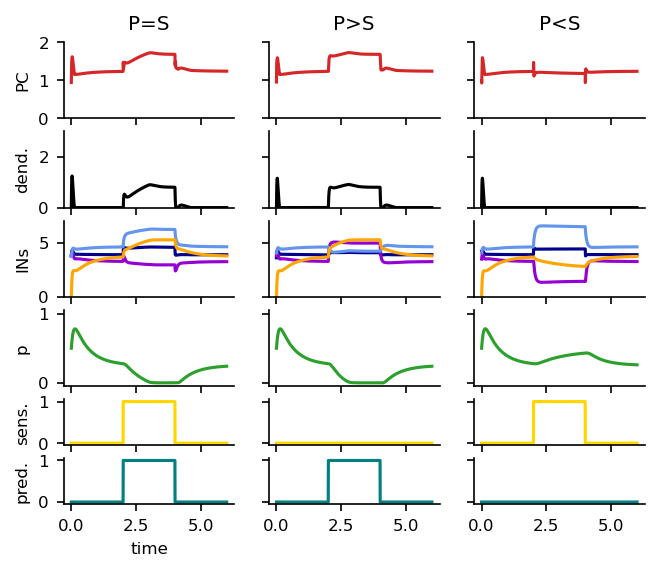

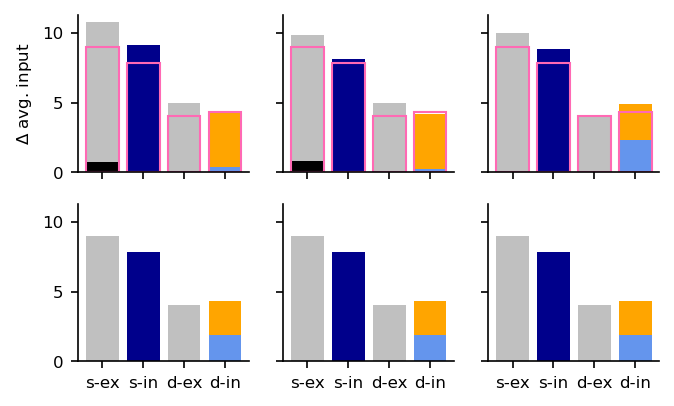

In [14]:
fig, ax = plt.subplots(6, 3, dpi=150, figsize=(5, 4), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.6, 0.6]}, sharey='row')
titles = ['P=S', 'P>S', 'P<S']

for i, cond in enumerate(['fp', 'op', 'up']):
    ax[0, i].plot(t, eval('rE'+cond), c='C3')
    ax[1, i].plot(t, eval('rD'+cond), c='k')
    ax[2, i].plot(t, eval('rP'+cond), c='darkblue')
    ax[2, i].plot(t, eval('rV'+cond), c='darkviolet')
    ax[2, i].plot(t, eval('rS'+cond), c='cornflowerblue')
    ax[2, i].plot(t, eval('rN'+cond), c='orange')
    ax[3, i].plot(t, eval('p'+cond), c='C2')
    ax[4, i].plot(t, sensory[eval(cond+'_s')-buffer:eval(cond+'_e')+buffer], c='gold')
    ax[5, i].plot(t, prediction[eval(cond+'_s')-buffer:eval(cond+'_e')+buffer], c='teal')
    ax[0, i].set(title=titles[i])

# labels
ax[0, 0].set(ylabel='PC', ylim=[0, 2])
ax[1, 0].set(ylabel='dend.', ylim=[0, 3])
ax[2, 0].set(ylabel='INs', ylim=[0, 7])
ax[3, 0].set(ylabel='p', ylim=[-0.05, 1.05])
ax[4, 0].set(ylabel='sens.', ylim=[-0.05, 1.05])
ax[5, 0].set(ylabel='pred.', xlabel='time', ylim=[-0.05, 1.05])

plt.show()

# plot excitation and inhibition to soma and dendrite
fig1, ax1 = plt.subplots(2, 3, dpi=150, figsize=(5, 3), sharey=True, sharex=True)
ts, te = buffer, dur-buffer

for i, cond in enumerate(['fp', 'op', 'up']): 
    soma_exc = np.mean((model.wED * eval('rD'+cond) + eval('xFF'+cond)['E'] + model.Xbg['E']), axis=1)
    soma_inh = np.mean((model.Ws['EP'] @ eval('rP'+cond).T), axis=0)
    dend_exc = np.mean((model.Ws['DE'] @ eval('rE'+cond).T + eval('xFF'+cond)['D'] + model.Xbg['D']), axis=0)
    dend_inh = np.mean((eval('p'+cond)*(model.Ws['DS'] @ eval('rS'+cond).T) + model.Ws['DN'] @ eval('cGABA'+cond).T), axis=0)

    ED = np.mean(model.wED * eval('rD'+cond), axis=1)
    xE = np.mean(eval('xFF'+cond)['E'] + model.Xbg['E'], axis=1)
    EP = np.mean((model.Ws['EP'] @ eval('rP'+cond).T), axis=0)
    DE = np.mean((model.Ws['DE'] @ eval('rE'+cond).T), axis=0)
    xD = np.mean(eval('xFF'+cond)['D'] + model.Xbg['D'], axis=1)
    DS = np.mean((eval('p'+cond)*(model.Ws['DS'] @ eval('rS'+cond).T)), axis=0)
    DN = np.mean((model.Ws['DN'] @ eval('cGABA'+cond).T), axis=0)

    # during stimulus/prediction
    plot_stacked_bar(['s-ex'], [ED, xE], c=['k', 'silver'], ax=ax1[0, i], ts=ts, te=te)
    plot_stacked_bar(['s-in'], [EP], c=['darkblue'], ax=ax1[0, i], ts=ts, te=te)
    plot_stacked_bar(['d-ex'], [DE, xD], c=['C3', 'silver'], ax=ax1[0, i], ts=ts, te=te)
    plot_stacked_bar(['d-in'], [DS, DN], c=['cornflowerblue', 'orange'], ax=ax1[0, i], ts=ts, te=te)

    # baseline for comparison
    s_ex_bl = plot_stacked_bar(['s-ex'], [ED, xE], c=['k', 'silver'], ax=ax1[1, i], ts=200, te=ts)
    s_in_bl = plot_stacked_bar(['s-in'], [EP], c=['darkblue'], ax=ax1[1, i], ts=200, te=ts)
    d_ex_bl = plot_stacked_bar(['d-ex'], [DE, xD], c=['C3', 'silver'], ax=ax1[1, i], ts=200, te=ts)
    d_in_bl = plot_stacked_bar(['d-in'], [DS, DN], c=['cornflowerblue', 'orange'], ax=ax1[1, i], ts=200, te=ts)

    ax1[0, i].bar([0, 1, 2, 3], [s_ex_bl, s_in_bl, d_ex_bl, d_in_bl], color='None', edgecolor='hotpink')

    # ax1[i].bar(['s-ex', 's-in', 'd-ex', 'd-in'], [soma_exc_diff, soma_inh_diff, dend_exc_diff, dend_inh_diff],
            #   color=['lightcoral', 'lightblue', 'darkred', 'darkblue'])
ax1[0, 0].set(ylabel=r'$\Delta$ avg. input')
plt.show()

In [15]:
model.Ws

{'NS': array([[0.7]]),
 'DS': array([[1.]]),
 'DN': array([[0.8]]),
 'SE': array([[1.]]),
 'NN': array([[0.2]]),
 'PS': array([[0.3]]),
 'PN': array([[0.1]]),
 'PP': array([[0.4]]),
 'PE': array([[1.2]]),
 'EP': array([[2.]]),
 'DE': array([[0.]]),
 'VS': array([[1.]]),
 'SV': array([[0.5]]),
 'PV': array([[0.15]]),
 'VE': array([[1.]]),
 'VN': array([[0.1]])}

In [16]:
model.Xbg

{'E': 9, 'D': 4.0, 'N': 2.8, 'S': 5.0, 'P': 6.199999999999999, 'V': 7.0}

In [17]:
xFF

{'E': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'D': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'S': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'N': array([[2.5],
        [2.5],
        [2.5],
        ...,
        [2.5],
        [2.5],
        [2.5]]),
 'P': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'V': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])}